[View in Colaboratory](https://colab.research.google.com/github/christian-rncl/Deep-Learning-SU18/blob/master/projects/cabbage_vs_lettuce/cabbage_vs_lettuce_part1.ipynb)

#Google colab setup

Make sure to set runtime to GPU

In [1]:
##Install torch
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch
print("torch installed: ", torch.__version__)

torch installed:  0.3.0.post4


In [2]:
 ##Install the fastai library
!pip install fastai

#Lettuce Vs Cabbages

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
#import fastai library
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [5]:
#check gpu setup
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

Set the path to data and download dataset. Dataset was scraped from google images and stored as  a zip file in my github

In [0]:
#set
PATH = "data/cabbagelettuce/"
sz=224

In [8]:
ls -a

./   .cache/   data/     data.zip   .ipython/  .wget-hsts
../  .config/  datalab/  .forever/  .local/


In [0]:
##comment line below to see LONG output of download and unzip
 %%capture
!mkdir data && wget https://github.com/christian-rncl/Deep-Learning-SU18/raw/master/projects/cabbage_vs_lettuce/data/data.zip && unzip data.zip -d data/cabbagelettuce

## Look at data 

In [10]:
import os
os.listdir(PATH)

['train', 'valid']

In [11]:
os.listdir(f'{PATH}valid')

['lettuce', 'cabbage']

In [12]:
os.listdir(f'{PATH}train')

['lettuce', 'cabbage']

In [13]:
files = os.listdir(f'{PATH}valid/lettuce')[:5]
files

['lettuce.40.jpg',
 'lettuce.29.jpg',
 'lettuce.31.jpg',
 'lettuce.0.jpg',
 'lettuce.2.jpg']

**Note:**
Loading images won't work in google colab without running the code below: <br>
source: https://stackoverflow.com/questions/48547660/attributeerror-module-pil-image-has-no-attribute-register-extensions

In [0]:
# workaround 
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

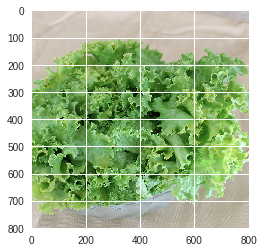

In [15]:
img = plt.imread(f'{PATH}valid/lettuce/{files[0]}')
plt.imshow(img);

In [16]:
img.shape

(800, 800, 3)

In [17]:
img[:4,:4]

array([[[212, 202, 192],
        [213, 203, 193],
        [213, 203, 193],
        [213, 203, 193]],

       [[212, 202, 192],
        [212, 202, 192],
        [212, 202, 192],
        [212, 202, 192]],

       [[212, 202, 192],
        [212, 202, 192],
        [212, 202, 192],
        [211, 201, 191]],

       [[212, 202, 192],
        [211, 201, 191],
        [211, 201, 191],
        [210, 200, 190]]], dtype=uint8)

##Training the model

First train conv net with the default settings from the lesson1 notebook without any data augmentation

In [47]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.0369, 2)

epoch      trn_loss   val_loss   accuracy   
    0      0.730304   0.509517   0.814815  
    1      0.523649   0.219711   0.901235  



[array([0.21971]), 0.9012345708446738]

## Analyzing initial results

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5).

In [48]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [49]:
# from here we know that 'cabbage' is label 0 and 'lettuce' is label 1.
data.classes

['cabbage', 'lettuce']

In [50]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(81, 2)

In [51]:
log_preds[:10]

array([[-0.02402, -3.7408 ],
       [-0.00353, -5.64953],
       [-0.00489, -5.32273],
       [-0.03346, -3.41398],
       [-0.03808, -3.28693],
       [-0.0031 , -5.77936],
       [-0.00127, -6.67265],
       [-0.00394, -5.53858],
       [-0.08902, -2.46305],
       [-0.07454, -2.63343]], dtype=float32)

In [0]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)


In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [0]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


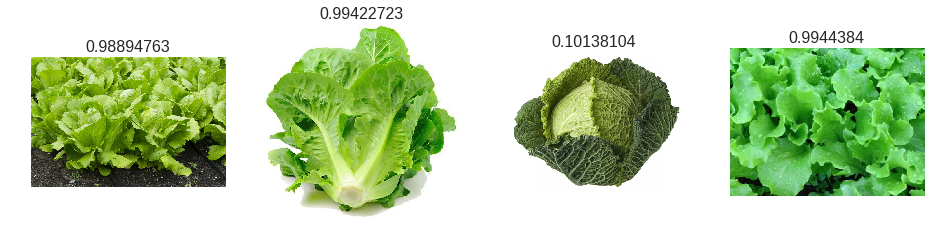

In [56]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


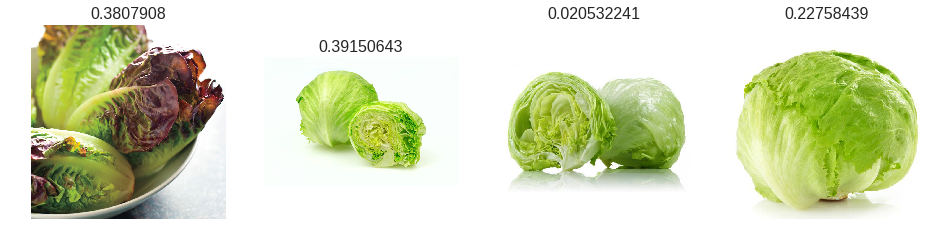

In [57]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cabbages


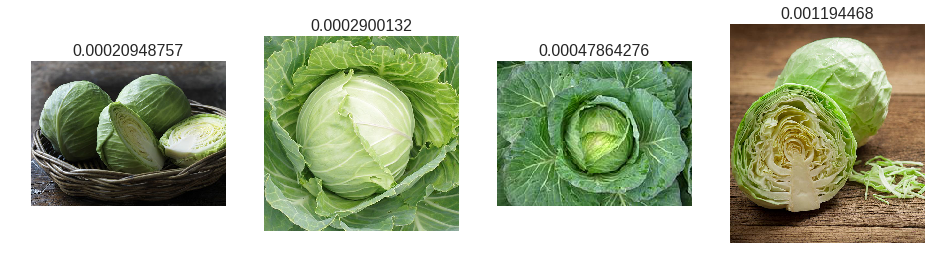

In [59]:
plot_val_with_title(most_by_correct(0, True), "Most correct cabbages")

Most correct lettuce


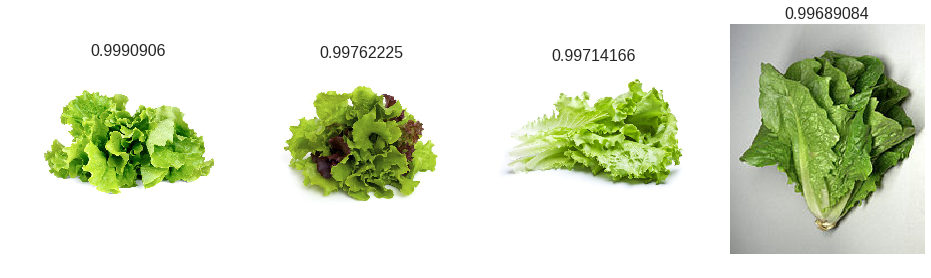

In [60]:
plot_val_with_title(most_by_correct(1, True), "Most correct lettuce")


In [61]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cabbage")

Most incorrect cabbage


Most incorrect lettuce


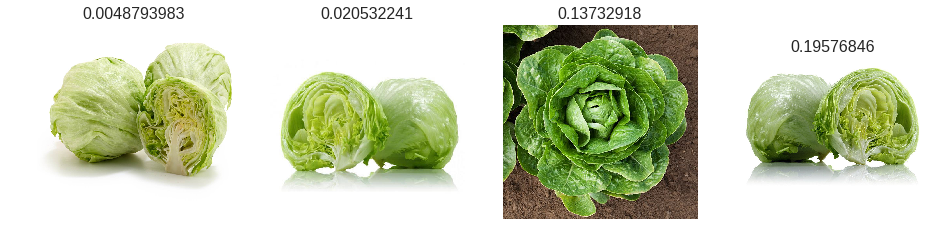

In [62]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect lettuce")

Most uncertain predictions


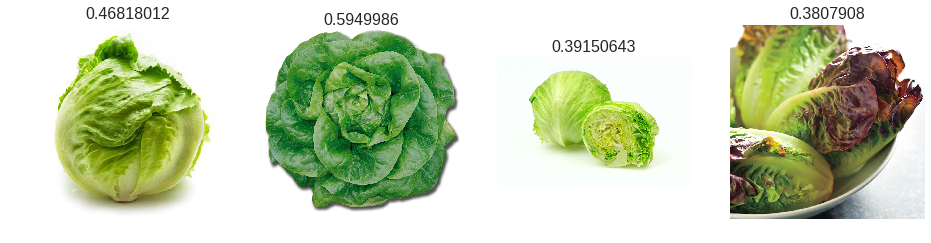

In [63]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

##Using techniques to choose learning rate and and number of epochs

The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affects model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

In [0]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [65]:
lrf=learn.lr_find()

epoch      trn_loss   val_loss   accuracy   
    0      0.809964   1.241929   0.802469  



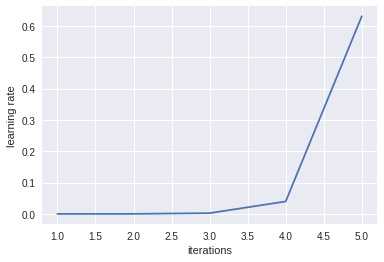

In [66]:
learn.sched.plot_lr()

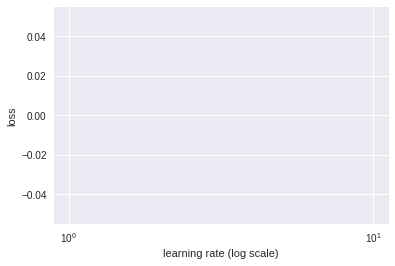

In [67]:
learn.sched.plot()

##Data Augmentation -- continued in part 2

Transform current data in ways that doesn't affect its interpretation (rotating and zooming). This creates more data in the training set and helps optimize our model. 

In [0]:
# from pprint import pprint
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
# pprint(tfms)

In [0]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [0]:
ims = np.stack([get_augs() for i in range(6)])

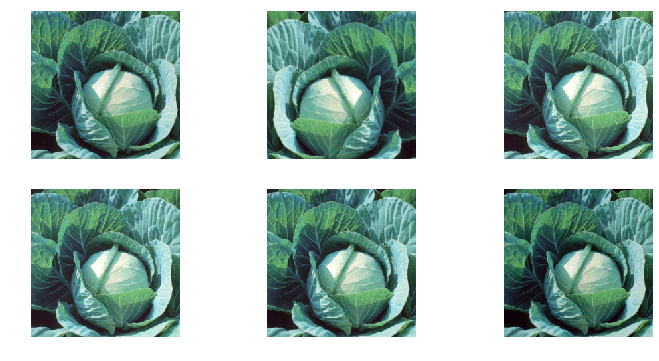

In [100]:
plots(ims, rows=2)

In [0]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [90]:
learn.fit(.08, 2)

epoch      trn_loss   val_loss   accuracy   
    0      0.048819   0.237597   0.901235  
    1      0.043786   0.220511   0.925926  



[array([0.22051]), 0.9259259281335054]

In [0]:
learn.precompute=False

In [95]:
learn.fit(.08, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.16275    0.250604   0.901235  
    1      0.139434   0.146113   0.925926  
    2      0.128948   0.131512   0.950617  


[array([0.13151]), 0.9506172846864771]

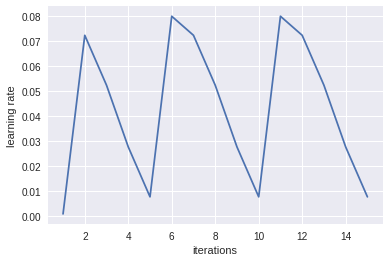

In [96]:
learn.sched.plot_lr()